In [ ]:
%%capture
!pip install gdown

In [ ]:
import gdown
id = '1LB53KldZ_hG_Kc2wEBmRjLH0Js80WGgr'
gdown.download(id=id, output='trainval.zip')

In [ ]:
%%capture
!unzip trainval.zip

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F
from skimage import io, color
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchmetrics import JaccardIndex
from tqdm import tqdm
import gc
import cv2

In [2]:
# Load images from folders A and B
folder_A = 'trainval/A'
folder_B = 'trainval/B'
folder_label = 'trainval/label'

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [4]:
print(device)

cpu


In [5]:
# Function to load images from directory
def load_images_from_folder(folder, is_gray = True):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename)).astype(np.uint8)
        if img is not None:
            if is_gray:
                images.append(color.rgb2gray(img))
            else:    
                images.append(img)
    return images


In [6]:
images_A = load_images_from_folder(folder_A, is_gray=False)

In [7]:
images_B = load_images_from_folder(folder_B, is_gray=False)

In [8]:
labels = load_images_from_folder(folder_label, is_gray = False)

In [18]:
no_changes = []
changes = []
for i in range(len(labels)):
    if np.sum(labels[i]) == 0:
        no_changes.append(i)
    else:
        changes.append(i)

In [19]:
print(f'Number of images with no changes: {len(no_changes)}')
print(f'Number of images with changes: {len(changes)}')

Number of images with no changes: 3232
Number of images with changes: 1636


In [20]:
reomve_no_changes = no_changes[:int(len(no_changes) * 0.5)]

In [21]:
print(len(reomve_no_changes))

1616


In [22]:
images_A = [images_A[i] for i in range(len(images_A)) if i not in reomve_no_changes]
images_B = [images_B[i] for i in range(len(images_B)) if i not in reomve_no_changes]
labels = [labels[i] for i in range(len(labels)) if i not in reomve_no_changes]

In [23]:
print(len(images_A), len(images_B), len(labels)) 

3252 3252 3252


In [26]:
zeros = 0
ones = 0
for label in labels:
    zeros += np.sum(label == 0)
    ones += np.sum(label == 255)

In [27]:
ones / zeros

0.11452409905554126

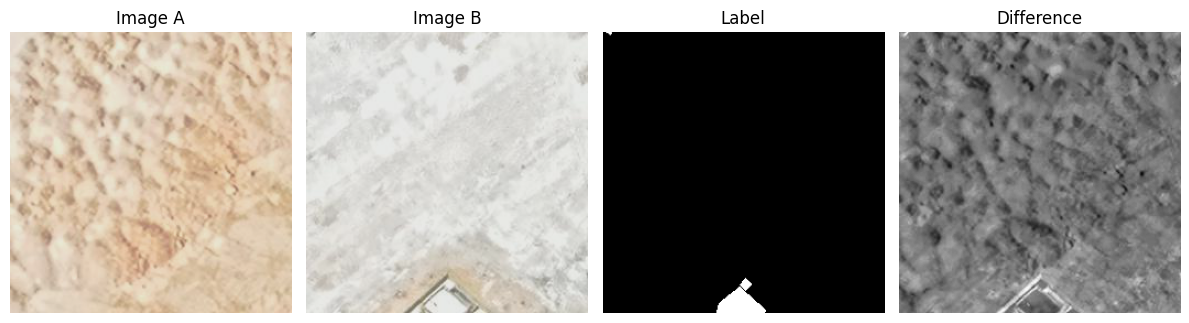

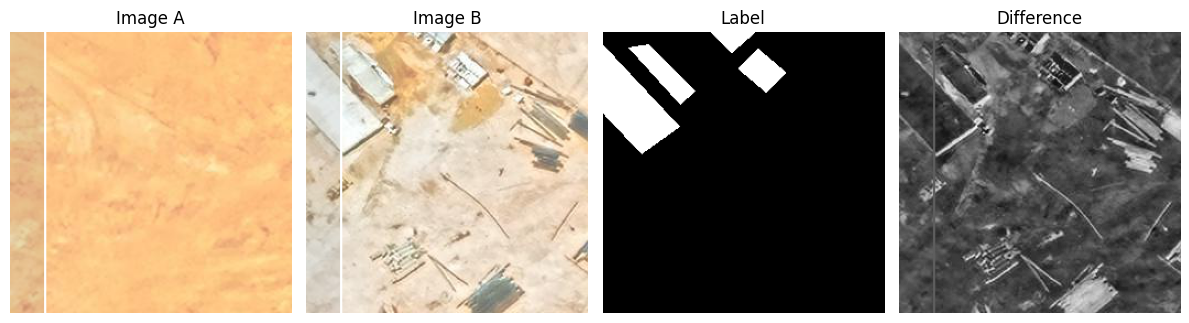

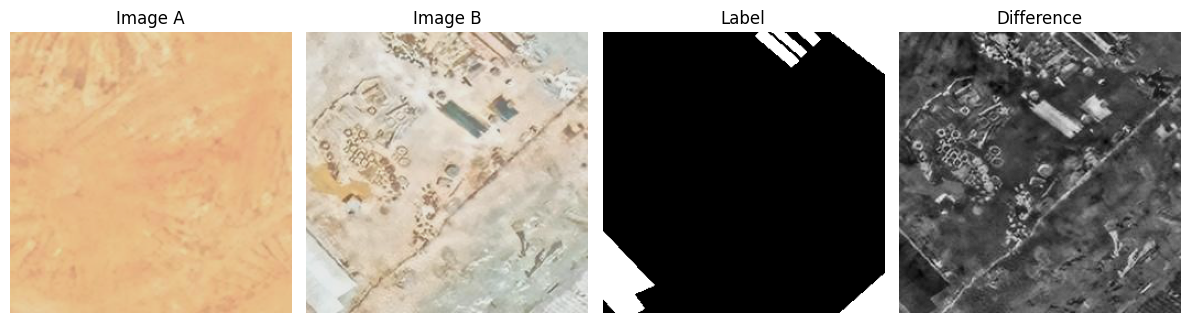

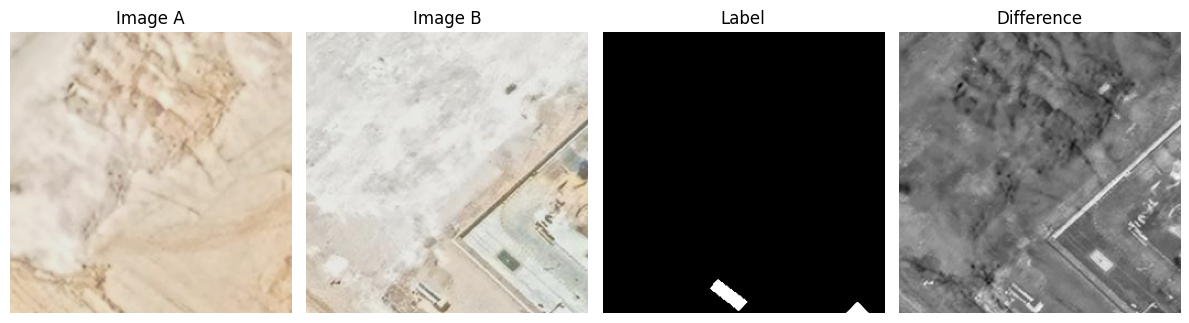

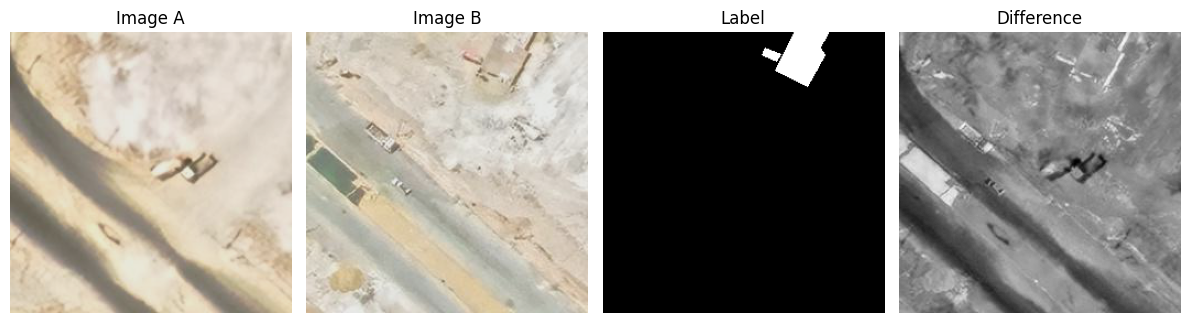

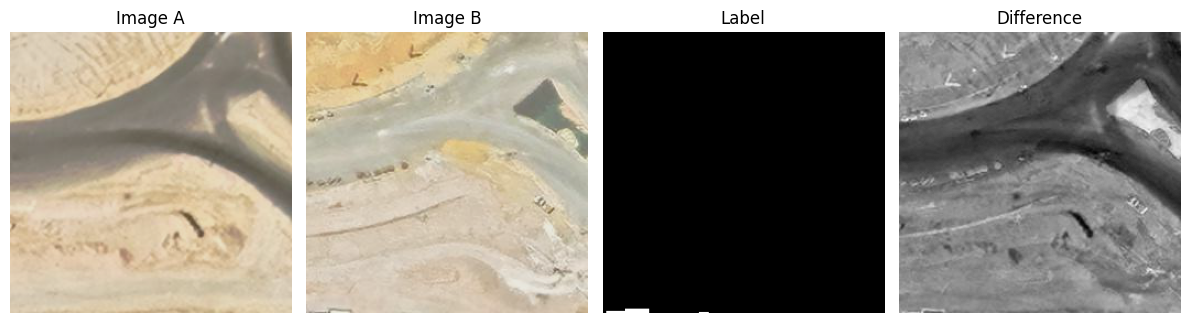

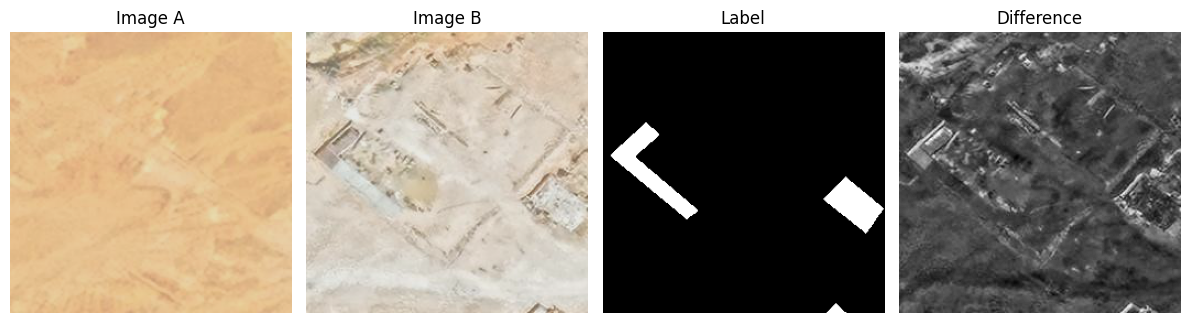

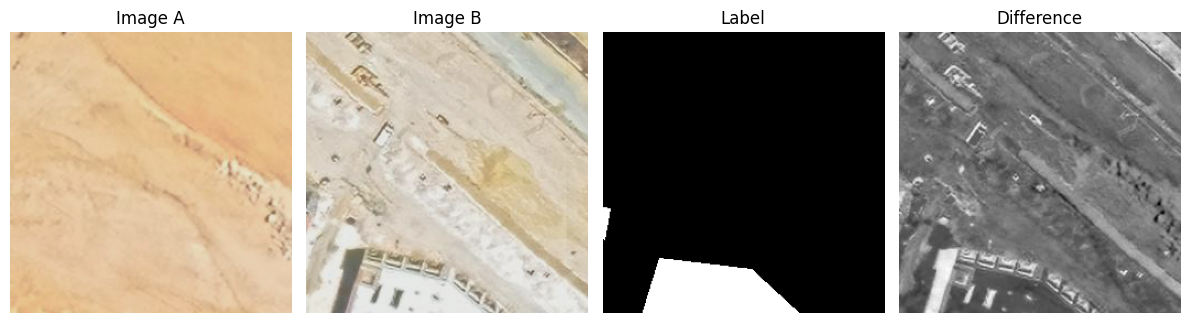

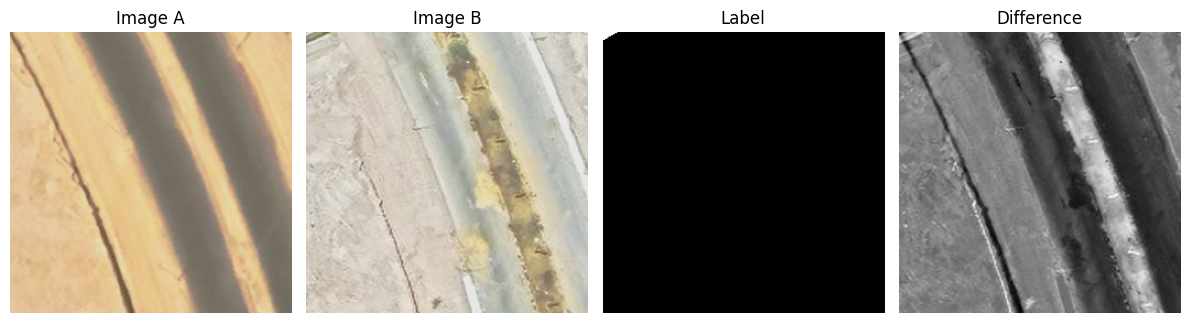

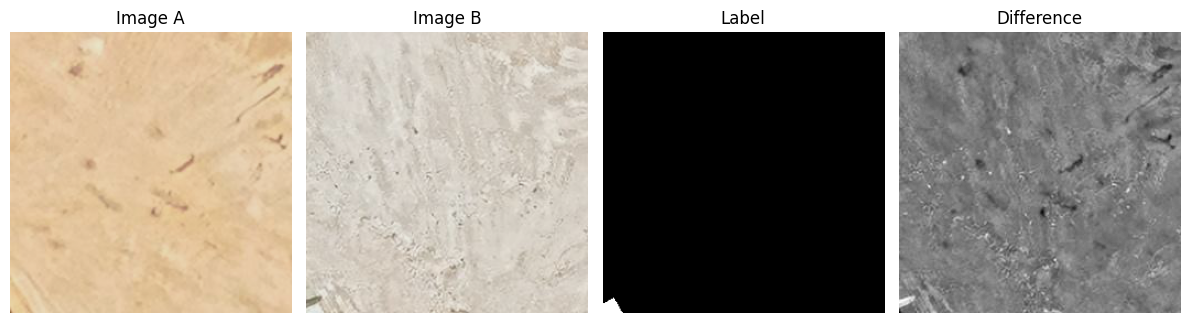

In [47]:
for i in range(120,130):
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    # Plot the first image
    axes[0].imshow(images_A[i])
    axes[0].set_title('Image A')

    # Plot the second image
    axes[1].imshow(images_B[i])
    axes[1].set_title('Image B')

    # Plot the third image
    axes[2].imshow(labels[i], cmap='gray')
    axes[2].set_title('Label')
    
    a = images_A[i].copy()
    b = images_B[i].copy()
    
    a = a.astype(np.float32)
    b = b.astype(np.float32)

    # Plot the fourth image
    diff = ((a - b) / (255 * 2)) + 0.5
    # print(diff_gray.min(), diff_gray.max())
    
    diff_gray = color.rgb2gray(diff)
    
    
    axes[3].imshow(diff_gray, cmap='gray')
    axes[3].set_title('Difference')

    # Remove the axis labels
    for ax in axes:
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5, 0.5),
])

In [13]:
class ChangeDetectionDataset(Dataset):
    def __init__(self, images_A, images_B, labels):
        self.images_A = images_A
        self.images_B = images_B
        self.labels = labels
#         self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_A = torch.tensor(self.images_A[idx], dtype=torch.float32).permute(2, 0, 1) / 255
        image_B = torch.tensor(self.images_B[idx], dtype=torch.float32).permute(2, 0, 1) / 255
        label = torch.tensor(self.labels[idx], dtype=torch.float32) / 255

#         if self.transform:
#             image_A = self.transform(image_A)
#             image_B = self.transform(image_B)
#             label = self.transform(label)

        return image_A, image_B, label

In [ ]:
class Channel_Attention(nn.Module):
    def __init__(self, channel):
        super(Channel_Attention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.query_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.key_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.value_conv = nn.Sequential(
            nn.Conv1d(in_channels=channel, out_channels=channel, kernel_size=1),
            )
        self.sigmoid = nn.Sigmoid()
        self.sm = nn.Softmax(-1)

        
    def forward(self, x):
        y = self.avg_pool(x)
        y = y.squeeze(-1).transpose(-1, -2)
        query = self.query_conv(y).transpose(-1, -2)
        key = self.key_conv(y)
        attention = torch.bmm(query, key)
        attention = self.sm(attention)
        value = self.value_conv(y)
        out = torch.bmm(value, attention).transpose(-1, -2).unsqueeze(-1)
        out = self.sigmoid(out)
        x = x * out.expand_as(x)
        return x

In [14]:
class DoubleConv(nn.Module):
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        ## Attention
        self.attention = Channel_Attention(in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        ## Attention
        x1 = self.attention(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [15]:
class UNet_Model(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_Model, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x_A, x_B):
        x = torch.cat([x_A, x_B], dim=1)
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = self.sigmoid(x)
        return x

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)
        self.sigmoid = torch.utils.checkpoint(self.sigmoid)

In [16]:
def dice_loss(pred, target, smooth=1):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=0).sum(dim=0)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=0).sum(dim=0) + target.sum(dim=0).sum(dim=0) + smooth)))
    loss = loss.mean()
    loss += F.binary_cross_entropy(pred,target) * 0.0
    return loss

In [17]:
def train(images_A, images_B, labels, num_epochs=10, batch_size=32, learning_rate=0.01):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = UNet_Model(n_channels=6, n_classes=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    print('Loading Data ...')
    dataset = ChangeDetectionDataset(images_A, images_B, labels)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    criterion = torch.nn.BCELoss()
    jaccard = JaccardIndex(task='binary').to(device)
    print('Training ...')
    for epoch_num in range(num_epochs):
#         scheduler.step()
        for param_group in optimizer.param_groups:
            print("LR", param_group['lr'])
        total_loss = 0
        total_intersections = 0
        total_unions = 0
        # number_of_batches = 0
        for a, b, l in tqdm(train_loader):
            # number_of_batches += 1
            a, b, l = a.to(device), b.to(device), l.to(device)
            optimizer.zero_grad()
            outputs = model(a,b)
            outputs = outputs.reshape((-1,l.shape[1],l.shape[2]))
            outputs_binary = (outputs>0.5) * 1
            total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
            total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
#             loss = dice_loss(outputs,l,0)
            loss = criterion(outputs, l)
            total_loss += loss
            loss.backward()
            optimizer.step()
            
        epoch_loss = total_loss / len(images_A)
        epoch_jaccard = total_intersections / total_unions
        print(
        f'Epochs: {epoch_num + 1} | Loss: {epoch_loss} | Jaccard Index : {epoch_jaccard} \n')
        
    print('Validation ...')
    model.eval()
    val_total_intersections = 0
    val_total_unions = 0
    with torch.no_grad():
        for a, b, l in tqdm(train_loader):
            a, b, l = a.to(device), b.to(device), l.to(device)
            outputs = model(a,b)
            outputs = outputs.reshape((-1,l.shape[1],l.shape[2]))
            outputs_binary = (outputs>0.5) * 1
            val_total_intersections += np.logical_and(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
            val_total_unions += np.logical_or(outputs_binary.cpu().numpy(), l.cpu().numpy()).sum()
        
    val_jaccard = val_total_intersections / val_total_unions
    print(f'Validation Jaccard Index : {val_jaccard}')
    return model

In [18]:
model = train(images_A, images_B, labels, num_epochs=10, batch_size=32, learning_rate=0.1)

Loading Data ...
Training ...
LR 0.1


100%|██████████| 122/122 [01:37<00:00,  1.26it/s]


Epochs: 1 | Loss: 0.0049923793412745 | Jaccard Index : 0.0031861663632013963 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 2 | Loss: 0.00402836874127388 | Jaccard Index : 0.05325130984100951 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 3 | Loss: 0.0035417943727225065 | Jaccard Index : 0.31484334090416294 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 4 | Loss: 0.0032950490713119507 | Jaccard Index : 0.3651625877619 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 5 | Loss: 0.0033260672353208065 | Jaccard Index : 0.38209782589388686 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 6 | Loss: 0.00321668921969831 | Jaccard Index : 0.3907715583174974 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 7 | Loss: 0.003064727410674095 | Jaccard Index : 0.40806378823439543 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 8 | Loss: 0.0029691027011722326 | Jaccard Index : 0.43019686405185803 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 9 | Loss: 0.0028462023474276066 | Jaccard Index : 0.44666728433218356 

LR 0.1


100%|██████████| 122/122 [01:35<00:00,  1.27it/s]


Epochs: 10 | Loss: 0.002835735445842147 | Jaccard Index : 0.44237585382272465 

Validation ...


100%|██████████| 122/122 [00:36<00:00,  3.33it/s]


Validation Jaccard Index : 0.4116219509593746


In [19]:
# gc.collect()
# torch.cuda.empty_cache()